## Import thư viện & dữ liệu

In [63]:
# Data 
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import pearsonr
from statsmodels.stats import weightstats as stests
pd.options.mode.chained_assignment = None  # default='warn'
# Plot 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# Machine Learning 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
# For evaluating ML 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

In [64]:
# read data sheet
xlsx_name = 'data_student_learning_habit_covid19-200408.xlsx'
sheet_name = 'data_student_learning_habit_cov'
raw_df = pd.read_excel(xlsx_name, sheet_name = sheet_name)
raw_df.head()

,stt,Gender,Class,Grade_level,school_type,Sib,fa_job,mo_job,income,exam,...,eff_supp,eff_env,eff_obj,eff_resource,eff_friend,kno_med,kno_covid,kno_env,kno_soci,kno_elearn
0,1,1,4,1,2,2,1,2,2,5,...,5,4,3,4,4,5,5,4,3,2
1,2,2,4,1,2,3,1,2,3,5,...,2,4,3,4,4,4,4,4,4,2
2,3,1,4,1,2,2,2,2,2,2,...,2,4,3,4,2,4,4,4,4,3
3,4,2,4,1,2,2,1,2,3,2,...,3,4,4,4,4,5,5,4,3,3
4,5,3,4,1,2,2,1,2,2,5,...,2,5,4,5,3,5,5,4,3,2


## Trực quan hóa dữ liệu số giờ tự học.

Trực quan sự phân phối dữ liệu của số giờ học trung bình dựa trên khối lớp và phân loại theo các loại trường khác nhau.

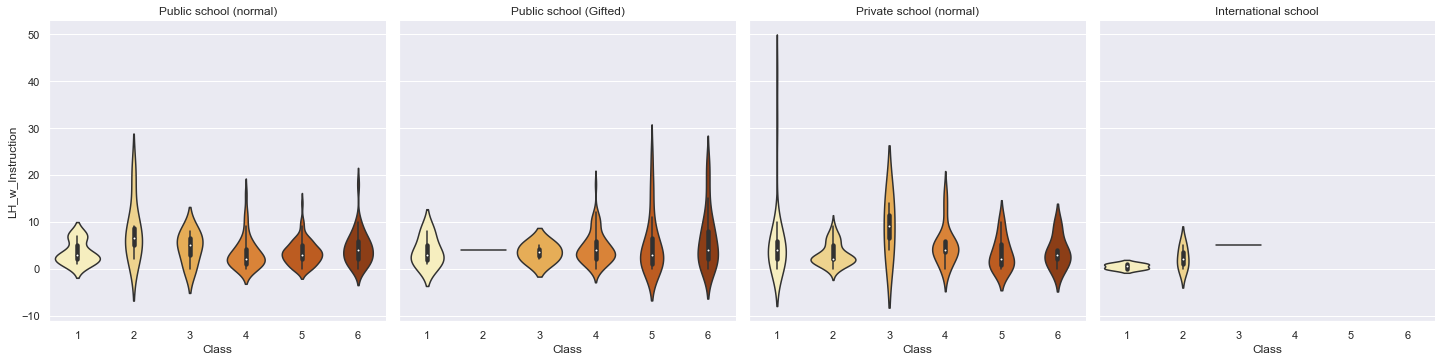

In [72]:
df_schooltype = raw_df[['Class','LH_w_Instruction','school_type']]
g = sns.catplot(x='Class',y='LH_w_Instruction',data= df_schooltype,kind='violin',col='school_type',palette='YlOrBr')
for ax, title in zip(g.axes.flat, ['Public school (normal)','Public school (Gifted)','Private school (normal)','International school']):
    ax.set_title(title)

Sử dụng violin plot giúp hiển thị toàn bộ phân phối dữ liệu. Đây là loại plot bao gồm box plot ở trọng tâm: chấm trắng thể hiện trung vị (median) của dữ liệu, thanh xám thể hiện tứ phân vị. Đối xứng 2 bên hiển thị phân phối mật độ của dữ liệu như Kernel density plot. Biểu đồ trên còn sử dụng màu sắc từ lợt đến đậm để hiển thị khối lớp tăng dần.

Từ biểu đồ vẽ được, ta thấy:
- Dữ liệu phân phối qua các khối lớp là đa dạng.
- **Lớp 1 trường công** có phân phối 2 đỉnh rõ rệt, phần lớp quan sát tập trung ở đỉnh lớn. **Trường quốc tế** có phân bố dữ liệu hẹp, có thể do có ít quan sát.
- **Trường công** có các trung vị tương đối gần nhau, khoảng 3 giờ. Trong khi **trường tư** và **trường quốc tế** sự chênh lệch này là nhiều hơn, đặc biệt ở **lớp 3 trường tư** (gần 9 giờ).
- **Lớp 1 trường tư** có một vài giá trị ngoại lệ khiến phân phối bị kéo lệch lên trên. Một số điểm ngoại lệ có thể xuất hiện ở **lớp 2 trường công**, **lớp 5, 6 trường chuyên**.
- Một số loại không có hình như **lớp 2 trường công chuyên**, **lớp 3 trường quốc tế** vì chỉ có 1 vài quan sát. Các *lớp 4, 5, 6 trường quốc tế* không có quan sát nào.

Thống kê trung bình số giờ tự học của học sinh **cấp 2** và **cấp 3**.

In [70]:
df_gradelevel = raw_df[['LH_w_Instruction','Grade_level']]
df_gradelevel['Grade_level'] = df_gradelevel['Grade_level'].replace({1: 'Secondary school', 2: 'High school'})
df_gradelevel = df_gradelevel.groupby('Grade_level')[['LH_w_Instruction']].agg('mean')
df_gradelevel

,LH_w_Instruction
Grade_level,
High school,4.354839
Secondary school,4.299145


Trực quan hóa dữ liệu trên:

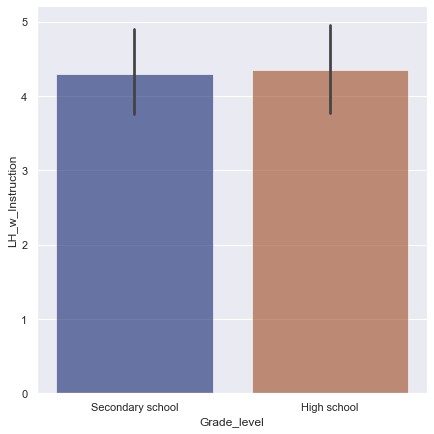

In [68]:
df_gradelevel = raw_df[['LH_w_Instruction','Grade_level']]
df_gradelevel['Grade_level'] = df_gradelevel['Grade_level'].replace({1: 'Secondary school', 2: 'High school'})
g = sns.catplot(data=df_gradelevel, kind="bar",x="Grade_level", y = 'LH_w_Instruction',palette="dark", alpha=.6, height=6)

Với **bar plot** trên, ta thấy: 
- Nhìn chung, thời gian tự học của khối **cấp 2** và **cấp 3** là tương đối như nhau. 
- Thanh error bars phía trên cho thấy đại diện cho sự thay đổi của dữ liệu cũng gần như tương đương nhau.

## Kiểm định thống kê

Để chắc chắn, ta sẽ kiểm định thống kê thời gian tự học trung bình 2 tổng thể trên. Sử dụng kiểm định 2 mẫu Z-test, ta có:
- Giả thuyết (null hypothesis): trung bình thời gian tự học của 2 mẫu là bằng nhau.

    $H_{0}: \mu_{1} = \mu_{2}$  
- Đối thuyết (alternative hypothesis): trung bình thời gian tự học của 2 mẫu là khác nhau.

    $H_{1}: \mu_{1} \neq \mu_{2}$ 

- Mức ý nghĩa $\alpha = 0.05$

In [69]:
alpha = 0.05

ztest ,pval1 = stests.ztest(df_gradelevel['LH_w_Instruction'][df_gradelevel['Grade_level'] == 'Secondary school'], x2=df_gradelevel['LH_w_Instruction'][df_gradelevel['Grade_level'] == 'High school'], value=0,alternative='two-sided')

print('stat=%.3f, p=%.3f' % (ztest, pval1))

if pval1 < alpha:
    print("Bác bỏ giả thuyết H0.")
else:
    print("Không đủ cơ sở bác bỏ giả thuyết H0.")

stat=-0.128, p=0.898
Không đủ cơ sở bác bỏ giả thuyết H0.


Kết luận: với mức ý nghĩa $\alpha = 0.05$, ta không đủ cơ sở để bác bỏ giả thuyết $H_{0}$. Nghĩa là trung bình thời gian tự học của **cấp 2** bằng trung bình thời gian tự học **cấp 3**. 

## Thống kê mô tả một số thuộc tính

In [5]:
# only get continuous value
df = raw_df[['Total_Online','LHInstruction','LH_w_Instruction','onl_instr','onl_noninstr','Total_offline','off_instr','off_noninstr']]

# create means' interval table
stat_table = pd.DataFrame()

# calculate means' interval
for column in df:
    column_mean = st.norm.interval(0.95,loc=np.mean(df[column]),scale=st.sem(df[column]))
    stat_table[column] = pd.Series(column_mean)

print('Với độ tin cậy 95%, ta có bảng ước lượng các giá trị trung bình như sau:')
stat_table.rename(index={0:'Mean-e',1:'Mean+e'})

Với độ tin cậy 95%, ta có bảng ước lượng các giá trị trung bình như sau:


,Total_Online,LHInstruction,LH_w_Instruction,onl_instr,onl_noninstr,Total_offline,off_instr,off_noninstr
Mean-e,2.420834,1.132507,3.900730,0.600751,1.734016,2.662666,0.485793,2.095682
Mean+e,3.031547,1.538921,4.746889,0.861153,2.256460,3.204001,0.723731,2.561461


Ta xem xét số giờ học tự học trong thời Covid-19.

Text(0, 0.5, 'Frequency')

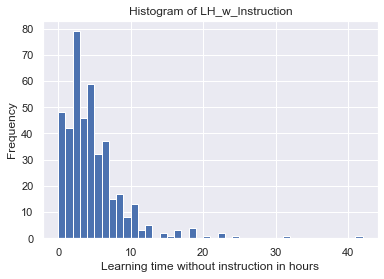

In [6]:
# calculate bins
Q1 = df['LH_w_Instruction'].quantile(0.25)
Q3 = df['LH_w_Instruction'].quantile(0.75)
IQR = Q3 - Q1
h = 2*IQR*pow(len(df),-1/3)
bin_num = round((df['LH_w_Instruction'].max()-df['LH_w_Instruction'].min())/h)

# draw hist
plt.hist(df['LH_w_Instruction'],bins=bin_num+3)
plt.title('Histogram of LH_w_Instruction')
plt.xlabel('Learning time without instruction in hours')
plt.ylabel('Frequency')

Trực quan nhanh bằng histogram chart, ta thấy:

- Biểu đồ phân bố lệch về bên trái. Nghĩa là $mode > median > mean$.

- Mức độ thường xuất hiện của thời gian tự học nằm trong khoảng từ 0 đến 6 giờ.

- Giá trị thường xuất hiện nhất là 2 giờ.

- Có 1 vài giá trị bất thường ở khoảng 20 đến 40 giờ, có thể đây là dữ liệu không hợp lệ.



## Hồi quy tuyến tính đơn giản 

Ta tìm hiểu liệu có mối liên hệ nào giữa số giờ tự học và số giờ học có hướng dẫn không.

Ta sẽ ước tính hệ số cho mô hình quy luật này. Hệ số được ước tính bằng cách sử dụng phương pháp bình phương nhỏ nhất (OLS).Với hàm mô tả dạng tuyến tính: 
$$y=\beta_{0}+\beta_{1}x$$

In [7]:
# create a fitted model with statsmodels
lm = smf.ols(formula='LH_w_Instruction ~ Total_offline', data=df).fit()

lm.params

Intercept        0.937791
Total_offline    1.154324
dtype: float64

In [8]:
# confidence intervals for the model coefficients
lm.conf_int()

,0,1
Intercept,0.524999,1.350583
Total_offline,1.052994,1.255655


Như vậy có thể thấy:

- Hệ số chặn $\beta_{0}$ (intercept) là 0.937791 với khoảng tin cậy là \[0.524999, 1.350583\]. Hệ số độ dốc $\beta_{1}$ (slope) là 1.154324 với khoảng tin cậy là \[1.052994, 1.255655\]. 

- Nghĩa là khi số giờ học ngoại tuyến (**Total_offline**) tăng 1 giờ thì số giờ tự học (**LH_w_Instruction**) tăng lên 1 giờ 9 phút.

- Phương trình hồi quy: LH_w_Instruction =  0.937791 + 1.154324 x Total_offline 


## Kiểm định thống kê

- Giả thuyết (null hypothesis): không có mối quan hệ giữa số giờ tự học và số giờ học ngoại tuyến.

    $H_{0}: \beta_{1} = 0$ 

- Đối thuyết (alternative hypothesis): có mối quan hệ giữa số giờ tự học và số giờ học ngoại tuyến.

    $H_{1}: \beta_{1} \neq 0$

- Mức ý nghĩa $\alpha = 0.05$

In [9]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       LH_w_Instruction   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     501.4
Date:                Thu, 15 Jul 2021   Prob (F-statistic):           1.49e-73
Time:                        11:35:00   Log-Likelihood:                -1054.5
No. Observations:                 420   AIC:                             2113.
Df Residuals:                     418   BIC:                             2121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9378      0.210      4.466

Xem rõ giá trị p-value:

In [10]:
lm.pvalues

Intercept        1.028612e-05
Total_offline    1.494396e-73
dtype: float64

statsmodels sử dụng độ tin cậy 95%, nghĩa là $\alpha=0.05$. Ta thấy p-value của số giờ học ngoại tuyến (`Total_offline`) có giá trị rất bé hơn so với $\alpha$ (1.494396e-73 << 0,05). Nghĩa là với mức ý nghĩa $\alpha$:
- Bác bỏ giả thuyết $H_{0}$.
- Nghĩa là có mối quan hệ giữa 2 biến **LH_w_Instruction** và **Total_offline**. 
- Biến **Total_offline** có ý nghĩa đối với mô hình về mặt thống kê (p-value = 1.494396e-73).
- Mô hình phù hợp tốt với dữ liệu quan sát về mặt thống kê (p-value = 1.494396e-73).
- Biến **Total_offline** có thể giải thích được 54.4% sự thay đổi của biến **LH_w_Instruction**.

## Kiểm định hệ số tương quan

Như vậy 2 biến trên có mối quan hệ tuyến tính, nghĩa là chúng không còn độc lập lẫn nhau. Ta có thể sử dụng hệ số tương quan (correlation coefficient) $Pearson$ để đo lường mức độ quan hệ tuyến tính giữa hai biến.

In [11]:
corr, p = pearsonr(df['LH_w_Instruction'], df['Total_offline'])
print('Pearson’s correlation coefficient: %.3f, Two-tailed p-value: %.3f' % (corr, p))
if corr <= 1 and corr >= 0.9:
	print('2 biến tương quan hoàn hảo.')
elif corr < 0.9 and corr >= 0.7:
    print('2 biến tương quan mạnh.')
elif corr < 0.7 and corr >= 0.5:
    print('2 biến tương quan vừa.')
elif corr < 0.5 and corr >= 0.1:
    print('2 biến tương quan yếu.')
else:
	print('2 biến không tương quan.')

Pearson’s correlation coefficient: 0.738, Two-tailed p-value: 0.000
2 biến tương quan mạnh.


## Phân tích hồi quy tuyến tính

Vậy còn tương quan giữa số giờ tự học và các thuộc tính còn lại thì sao? Ta thử xem xét bằng phân tích hồi quy tuyến tính bội.

In [12]:
# re-position
ln_df = df[['Total_Online','LHInstruction','onl_instr','onl_noninstr','Total_offline','off_instr','off_noninstr','LH_w_Instruction']]

# create LinearRegression object
lreg = LinearRegression()

X_multi = ln_df.drop('LH_w_Instruction',1)
Y_target = ln_df['LH_w_Instruction']

# implement linear regression
lreg.fit(X_multi,Y_target)

LinearRegression()

In [13]:
# create b1 table
coeff_df = pd.DataFrame(ln_df.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(lreg.coef_)

# show
coeff_df

,Features,Coefficient Estimate
0,Total_Online,0.428571
1,LHInstruction,-0.285714
2,onl_instr,-0.142857
3,onl_noninstr,0.571429
4,Total_offline,0.428571
5,off_instr,-0.142857
6,off_noninstr,0.571429
7,LH_w_Instruction,NaN


Bảng trên tập hợp các hệ số tương quan để đo lường mức độ mạnh yếu của mối quan hệ giữa hai biến số. 

Có thể thấy hệ số $\beta_{1}$ tương ứng với thuộc tính **Total_Online** là khá lớn so với các thuộc tính khác. Có nghĩa nó là thuộc tính tương quan tốt với **LH_w_Instruction**. Ta xem xét mối quan hệ giữa 2 thuộc tính này.

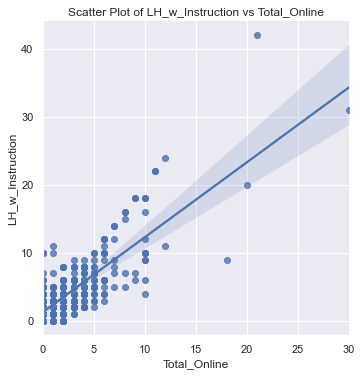

In [14]:
# draw simple linear fit
sns.lmplot(x = 'Total_Online', y = 'LH_w_Instruction', data = df).set(title='Scatter Plot of LH_w_Instruction vs Total_Online')

Dựa vào scatter plot trên, đúng như dự đoán:
- Biểu đồ có dạng tuyến tính. Bờ dốc dương, Y tăng khi X tăng.
- Các điểm phân tán không rộng mà tập trung xung quanh đường thẳng, mối quan hệ được coi là mạnh.
- Có thể thấy khi thời gian học trực tuyến tăng thì thời gian tự học cũng tăng theo.

Thực hiện huấn luyện bộ dữ liệu với `scikit-learn`.

In [77]:
X = df['Total_Online']
X = np.vstack(df['Total_Online'])

Y = np.ravel(df['LH_w_Instruction'])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

# see how data is splited up
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(315, 1) (105, 1) (315,) (105,)


Sau khi huấn luyện, ta có: 
- Bộ train gồm 315 dòng. Sử dụng để dự đoán giờ tự học. 
- Bộ test gồm 105 dòng. Sử dụng để validate dự đoán.

In [78]:
# do a linear regression with training sets
lreg.fit(X_train,Y_train)

# Predictions on training and testing sets
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test) 

In [79]:
rsquared_adj = 1-(1-r2_score(Y_test, pred_test))*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))
print('Adjusted R-squared: ', rsquared_adj)
print('Biến Total_Online có thể giải thích được', round(rsquared_adj*100,2), '% sự thay đổi của biến LH_w_Instruction')

Adjusted R-squared:  0.7360849086275543
Biến Total_Online có thể giải thích được 73.61 % sự thay đổi của biến LH_w_Instruction


In [80]:
print("R-MSE with Y_train: %.2f" %mean_squared_error(Y_train, pred_train,squared=False))
print("R-MSE with X_test and Y_test: %.2f"  %mean_squared_error(Y_test, pred_test,squared=False))

R-MSE with Y_train: 2.80
R-MSE with X_test and Y_test: 2.30


Ta nhận thấy root mean square error (R-MSE) giữa bộ train và bộ test khá gần nhau. 

Trong phân tích hồi quy, hiệu giá trị quan sát của biến phụ thuộc và giá trị dự đoán được gọi là phần dư (residual). Mỗi điểm dữ liệu có một phần dư:
$$Residual = Observed\:value - Predicted\:value $$

Do đó để kiểm định mô hình đã huấn luyện, ta có thể trực quan hóa bằng residual plots.

Text(0.5, 0, 'Fitted')

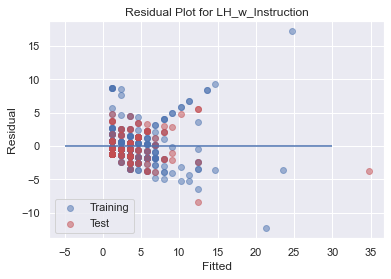

In [81]:
# scatter plot the training data
train = plt.scatter(pred_train,(Y_train-pred_train),c='b',alpha=0.5)

# scatter plot the testing data
test = plt.scatter(pred_test,(Y_test-pred_test),c='r',alpha=0.5)

# plot a horizontal axis line at 0
plt.hlines(y=0,xmin=-5,xmax=30)

# add labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plot for LH_w_Instruction')
plt.ylabel('Residual')
plt.xlabel('Fitted')

Nhận xét: 
- Residual plots là đồ thị biểu diễn phần dư trên trục tung và biến số độc lập trên trục hoành. 
- Các điểm trong một ô dư được phân tán ngẫu nhiên quanh trục hoành. Ta có thể kết luận đây là một mô hình hồi quy tuyến tính là thích hợp cho dữ liệu.

Để dự đoán thời gian tự học của 1 người mới, ta chỉ cần sử dụng lại kết quả của hồi quy tuyến tính trên. Ví dụ:

In [82]:
print('Một người có 3 giờ học trực tuyến sẽ có', lreg.predict(np.array([[3]]))[0], 'giờ tự học.')

Một người có 3 giờ học trực tuyến sẽ có 4.615625 giờ tự học.


## Phân tích hồi quy Logistic

Ta thử tìm mối liên hệ thời gian tự học đến xác suất việc 1 học sinh chăm học hơn (số giờ học sau khi có Covid nhiều hơn trước khi có Covid)

Ta sẽ sử dụng hồi quy Logistic để xem mối liên hệ này. Với mọi giá trị $t$ đầu vào, đầu ra luôn có giá trị từ 0 đến 1: $ \sigma (t)= \frac{1}{1+e^{-t}} $. Truyền vào với tham số $ t = \beta _0 + \beta _1 x $ là dạng biểu diễn hồi quy tuyến tính đơn. Ta có:
$$ F(x)= \frac{1}{1+e^{-(\beta _0 + \beta _1 x)}}$$

In [18]:
df2 = raw_df[['Lh_before_Cov','Lh_in_Cov','LH_w_Instruction']]
df2['is_increase'] = np.where(df2['Lh_in_Cov'] > df2['Lh_before_Cov'], 1, 0)

In [84]:
m = smf.logit(formula='is_increase ~ LH_w_Instruction',data=df2).fit()
print(m.summary())
#newpred = pd.DataFrame({"LH_w_Instruction": [5]})
#m.predict(newpred)

Optimization terminated successfully.
         Current function value: 0.582728
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_increase   No. Observations:                  420
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Jul 2021   Pseudo R-squ.:                 0.07200
Time:                        11:38:41   Log-Likelihood:                -244.75
converged:                       True   LL-Null:                       -263.74
Covariance Type:            nonrobust   LLR p-value:                 7.149e-10
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.4897      0.176     -8.482      0.000      -1.834      -1.145
LH_w_Instru

- Biến **LH_w_Instruction** (giờ tự học) có ý nghĩa đối với mô hình về mặt thống kê (p-value = 0.000)
- Nhưng mô hình chỉ giải thích được 7.2% sự thay đổi của biến **is_increase** (xét chăm học hơn không). Ta có thể thử trực quan hàm xác suất:

Text(0, 0.5, 'Increasing probility')

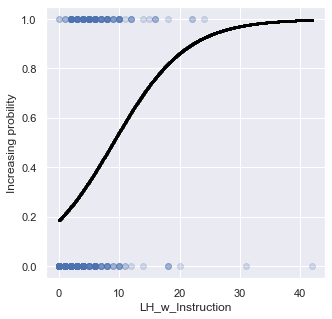

In [85]:
LHINew = pd.DataFrame({'LH_w_Instruction': np.linspace(df2["LH_w_Instruction"].min(), df2["LH_w_Instruction"].max(), 1000)})
predProbs = m.predict(LHINew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df2["LH_w_Instruction"], df2["is_increase"], color='b', alpha=0.20)
ax.scatter(LHINew, predProbs , color="black", s=4)
ax.set_xlabel('LH_w_Instruction')
ax.set_ylabel('Increasing probility')

Sau khi trực quan hàm xác suất thì đúng như vậy, ta có thể thấy:
- Mặc dù dạng đường xác suất tăng. Tức là số giờ tự học tăng thì xác suất học sinh chăm học hơn cũng tăng. 
- Nhưng đây không hoàn toàn là đường cong cho hồi quy logit tốt, đường xác suất không chạm tới 0. Hơn nữa, nhìn vào 2 biểu đồ phân bố thì cũng thấy số giờ học phân bố rải rác từ 0 tới 10 là chủ yếu mặc cho xác suất tăng.

### Tài liệu tham khảo

[1] Bùi Tiến Lên. Data Analysis. Đại học Khoa học Tự nhiên, 2021. 

[2] Nguyễn Tuấn. Biểu diễn dữ liệu với Box and Whisker Plot, 2021. URL: https://chidokun.github.io/2021/02/box-and-whisker-plot/

[3] Leila Gharani. Charting Survey Results in Excel, 2021. URL: https://www.xelplus.com/charting-survey-results-excel/

[4] Ritchie Ng. Evaluating a Linear Regression Model. URL: https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

[5] Jose Marcial Portilla. Udemy's course note, 2021. URL: https://github.com/jmportilla/Udemy---Machine-Learning/blob/master/Supervised%20Learning%20-%20%20Linear%20Regression.ipynb

[6] Jason Brownlee. 17 Statistical Hypothesis Tests in Python (Cheat Sheet), 2021. URL: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

[7] Ankit Das. Z-Tests vs T-Tests: How To Choose Among Two Important Hypothesis Tests, 2021. URL: https://analyticsindiamag.com/z-test-t-test-statistcs/